## CNN

In [4]:
%pip install split-folders

In [1]:
import os
print(os.listdir("Dataset"))

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [7]:
#Don't run the results were saved in "output" folder
import splitfolders

splitfolders.ratio('Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Copying files: 6360 files [01:48, 58.36 files/s]


In [61]:
#Run this cell to import all the necessary libraries

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt  
from sklearn.model_selection import ParameterGrid

In [2]:
#Run This Cell to load the split folders into DataLoaders

transform = transforms.Compose([#using the torchvision.transforms to convert the images to grayscale and normalize them
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create PyTorch datasets for the training and validation sets
trainset = torchvision.datasets.ImageFolder(root='output/train', transform=transform)
valset = torchvision.datasets.ImageFolder(root='output/val', transform=transform)
testset = torchvision.datasets.ImageFolder(root='output/test', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented')

c:\Users\abeda\anaconda3\envs\NC\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [4]:
img = Image.open("output/train/Mild_Demented/mild_136.jpg")

# Check the number of channels
num_channels = len(img.getbands())

print("Number of channels:", num_channels)

Number of channels: 1


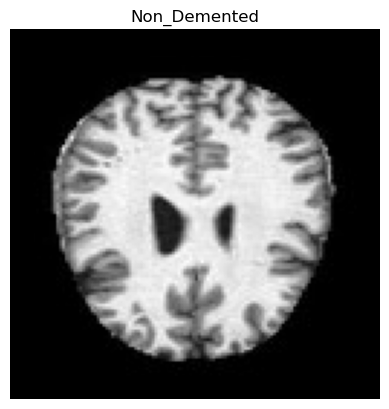

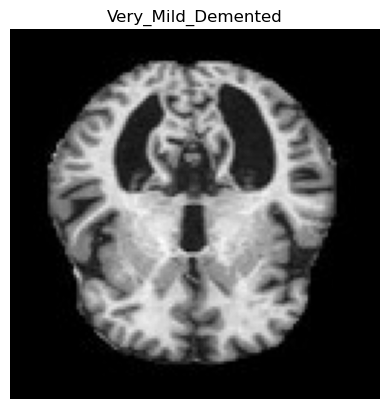

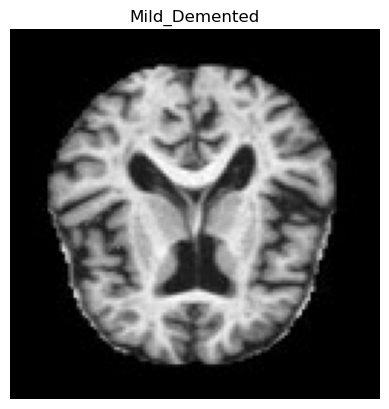

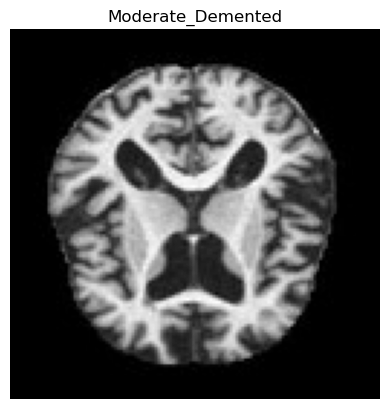

In [21]:

# Create dictionary to store one image per label
label_to_image = {}

# Iterate over images and store one image per label in dictionary
for images, labels in trainloader:
    for image, label in zip(images, labels):
        if label.item() not in label_to_image:
            label_to_image[label.item()] = image

# Plot one image per label with its corresponding label name
for label, image in label_to_image.items():
    # Convert image to numpy array for plotting
    img = image.numpy().transpose((1, 2, 0))

    # Plot image with its label
    plt.imshow(img[:,:,0], cmap = 'gray')
    plt.title(classes[label])
    plt.axis('off')
    plt.show()

In [41]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self, input_size,  kernel_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size, stride= 1, padding= 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size, stride= 1, padding= 1)

        # calculate the output size of the convolutional layers
        conv_output_size = self._get_conv_output_size(input_size, kernel_size)

        self.fc1 = nn.Linear(conv_output_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def _get_conv_output_size(self, input_size, kernel_size):
        """
        Calculates the output size of the convolutional layers based on the input size and kernel size.
        Assumes padding is same, stride is 1, and only MaxPool2d is used for pooling.
        """
        conv_output_size = input_size
        for i in range(2):  # two convolutional layers
            conv_output_size = (conv_output_size - kernel_size + 2) // 1 + 1  # calculate output size
            conv_output_size = (conv_output_size - 2) // 2 + 1  # apply max pooling
        return 32 * conv_output_size * conv_output_size

In [42]:
#Not for running (Took about 96 minutes to finish)
#Defining the parameters grid
input_size = 128
param_grid_2 = {'lr': [0.001, 0.003, 0.01, 0.1],
              'kernel_size': [5, 3]} 
grid_2 = ParameterGrid(param_grid_2)
best_accuracy = 0
# Train the model
for param in grid_2:
    print(f'Trying params: {param}')
    lr1 = param['lr']
    kernels = param['kernel_size']
    net = Net(input_size = input_size, kernel_size = kernels)
    optimizer = optim.SGD(net.parameters(), lr=lr1, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Validation
    net.eval()  # Set the network to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient tracking for efficiency
        for data in valloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_acc = (100 * correct / total)
        print('Accuracy on validation set with ',lr1,' learning rate:'' %d %%' % val_acc )
    net.train()  # Set the network back to training mode
    if val_acc > best_accuracy:
        # Update best accuracy
        best_accuracy = val_acc
        
        # Save model checkpoint
        torch.save(net.state_dict(), 'best_CNNmodel.pth')
print('Finished Training and Validation')

Trying params: {'kernel_size': 5, 'lr': 0.001}
Accuracy on validation set with  0.001  learning rate: 61 %
Trying params: {'kernel_size': 5, 'lr': 0.003}
Accuracy on validation set with  0.003  learning rate: 89 %
Trying params: {'kernel_size': 5, 'lr': 0.01}
Accuracy on validation set with  0.01  learning rate: 94 %
Trying params: {'kernel_size': 5, 'lr': 0.1}
Accuracy on validation set with  0.1  learning rate: 50 %
Trying params: {'kernel_size': 3, 'lr': 0.001}
Accuracy on validation set with  0.001  learning rate: 57 %
Trying params: {'kernel_size': 3, 'lr': 0.003}
Accuracy on validation set with  0.003  learning rate: 77 %
Trying params: {'kernel_size': 3, 'lr': 0.01}
Accuracy on validation set with  0.01  learning rate: 96 %
Trying params: {'kernel_size': 3, 'lr': 0.1}
Accuracy on validation set with  0.1  learning rate: 69 %
Finished Training and Validation


In [ ]:
#Don't run (the output file has already been saved)
#Loading the best obtained parameters from the previous cell (training)
cnn = Net(128, 3)
cnn.load_state_dict(torch.load('best_CNNmodel.pth'))
#Combining the train and validation to train the final model on 90% of the data before testing it on unseen data
combined_set = torch.utils.data.ConcatDataset([trainset, valset])
combined_loader = torch.utils.data.DataLoader(combined_set, batch_size=32, shuffle=True)

optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
for epoch in range(10):
    for i, (images, labels) in enumerate(combined_loader):
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

best_model_fullytrained = torch.save(cnn.state_dict(), 'best_CNNmodel_fullytrained.pth')

Accuracy of the network on the 638 test images: 99 %


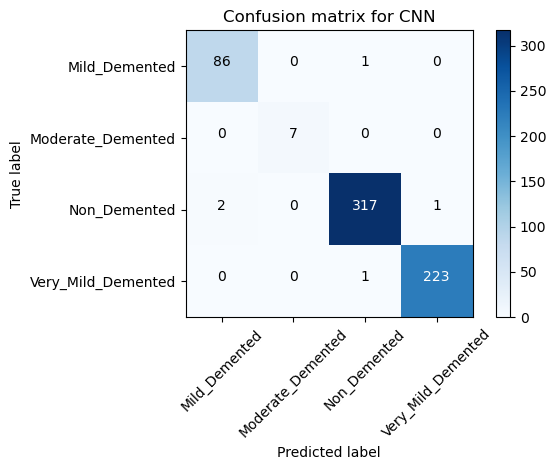

In [65]:
#Run this cell to test the model's performance on the unseen set
#Loading the best trained model from the saved file
cnn = Net(128, 3)
cnn.load_state_dict(torch.load('best_CNNmodel_fullytrained.pth'))
correct = 0
total = 0
predicted_labels = []
true_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels += predicted.tolist()
        true_labels += labels.tolist()  
print(f'Accuracy of the network on the 638 test images: {100 * correct // total} %')

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for CNN')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

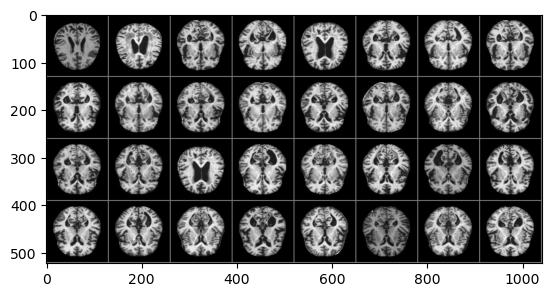

GroundTruth:  Mild_Demented Mild_Demented Mild_Demented Mild_Demented Mild_Demented Mild_Demented Mild_Demented Mild_Demented


In [50]:
#Optional
#Plotting a batch of the test set along with their actual labels, followed by the predicted labels in the next cell
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [53]:
outputs = cnn(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

Predicted:  Mild_Demented Mild_Demented Non_Demented Mild_Demented Mild_Demented Mild_Demented Mild_Demented Mild_Demented


## MLP

In [6]:
#Defining the MLP's architecture (NO NEED TO RUN)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x


In [18]:
#Don't RUN (Output has already been saved, and it took about 42 min)
#Defining the parameter grid and training each iteration with a different tuple
param_grid = {'hidden_size': [64, 128, 256], 'lr': [ 0.003, 0.01, 0.03], 'momentum': [0.3, 0.9]}
grid = ParameterGrid(param_grid)
best_acc = 0.0
best_model = None
best_params = {}
num_classes = 4
input_size = 128*128
num_epochs = 10
for params in grid:
    print(f'Trying params: {params}')

    hidden_size = params['hidden_size']
    lr = params['lr']
    momentum = params['momentum']
    model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

    # Early stopping variables
    best_val_acc = 0
    epochs_no_improve = 0
    max_epochs_stop = 10

    for epoch in range(10):
        for i, (images, labels) in enumerate(trainloader):

            outputs = model(images.view(images.size(0), -1))
            loss = criterion(outputs, labels)
            #/ Add weight decay term to loss
            #l2_reg = torch.tensor(0.)
            #for param in model.parameters():
                #l2_reg += torch.norm(param)
            #loss += weight_decay * l2_reg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validate the model
        with torch.no_grad():
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            for images, labels in valloader:
                outputs = model(images.view(images.size(0), -1))
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
            val_acc = 100 * correct_val / total_val

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                num_epochs_no_improve = 0
            else:
                num_epochs_no_improve += 1

            if num_epochs_no_improve == 3:
                print(f"Stopping early after {epoch} epochs, with validation accuracy of {best_val_acc}")
                break

        # Print loss when maximum epochs are reached
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} loss: {loss.item():.4f} validation accuracy: {val_acc:.4f}")

    # Store best model
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_params = {'learning_rate': lr, 'hidden_size': hidden_size, 'momentum': momentum}
        best_model = model.state_dict()

print(f"Best validation accuracy of {best_acc:.4f} found with learning rate = {best_params['learning_rate']} and hidden size = {best_params['hidden_size']} and momentum of: {best_params['momentum']:.4f}")
# Save the best model as a file
torch.save(best_model, 'best_model_MLP.pt')

Trying params: {'hidden_size': 64, 'lr': 0.003, 'momentum': 0.3}
Epoch 10/10 loss: 1.2234 validation accuracy: 59.3701
Trying params: {'hidden_size': 64, 'lr': 0.003, 'momentum': 0.9}
Stopping early after 8 epochs, with validation accuracy of 62.51968503937008
Trying params: {'hidden_size': 64, 'lr': 0.01, 'momentum': 0.3}
Epoch 10/10 loss: 1.1013 validation accuracy: 62.6772
Trying params: {'hidden_size': 64, 'lr': 0.01, 'momentum': 0.9}
Stopping early after 4 epochs, with validation accuracy of 60.47244094488189
Trying params: {'hidden_size': 64, 'lr': 0.03, 'momentum': 0.3}
Epoch 10/10 loss: 1.0734 validation accuracy: 56.2205
Trying params: {'hidden_size': 64, 'lr': 0.03, 'momentum': 0.9}
Stopping early after 3 epochs, with validation accuracy of 50.39370078740158
Trying params: {'hidden_size': 128, 'lr': 0.003, 'momentum': 0.3}
Stopping early after 3 epochs, with validation accuracy of 50.39370078740158
Trying params: {'hidden_size': 128, 'lr': 0.003, 'momentum': 0.9}
Stopping ear

In [55]:
#Don't RUN, the output file has already been saved at the end of the cell
#Loading the best obtained parameters from the previous cell
mlp = MLP(128*128, 128, 4)
mlp.load_state_dict(torch.load('best_model_MLP.pt'))
#Retraining the MLP with the best found paramaters on the combined train+validation sets
combined_set = torch.utils.data.ConcatDataset([trainset, valset])
combined_loader = torch.utils.data.DataLoader(combined_set, batch_size=32, shuffle=True)
optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.3)
criterion = nn.CrossEntropyLoss()
for epoch in range(10):
    for i, (images, labels) in enumerate(combined_loader):
        optimizer.zero_grad()
        outputs = mlp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

best_mlp_fullytrained = torch.save(mlp.state_dict(), 'best_mlp_fullytrained.pt')

Accuracy of the network on the 638 test images: 65 %


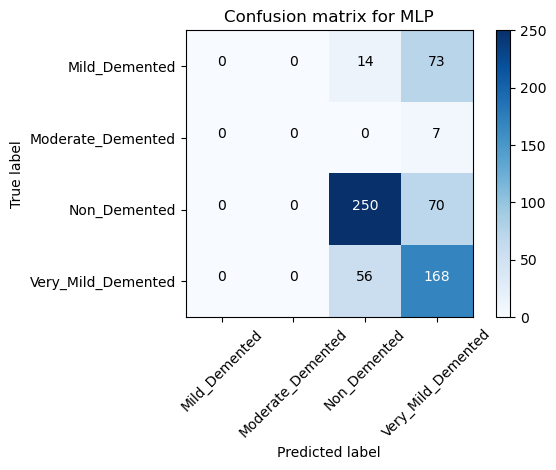

In [64]:
#In order to run the model on the test set, run this cell 
#Loading the best fully trained model from the saved file
mlp = MLP(128*128, 128, 4)
mlp.load_state_dict(torch.load('best_mlp_fullytrained.pt'))
correct = 0
total = 0
predicted_labels = []
true_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = mlp(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels += predicted.tolist()
        true_labels += labels.tolist()      
print(f'Accuracy of the network on the 638 test images: {100 * correct // total} %')

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for MLP')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## SVM

In [15]:
#SVM code was left as supplementary negative outcome as described in the appendix.
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def flatten(x):
    return x.view(x.size()[0], -1)
param_grid = {'estimator__C': [0.1, 1, 10, 100],
              'estimator__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

combined_set = torch.utils.data.ConcatDataset([trainset, valset])
combined_loader = torch.utils.data.DataLoader(combined_set, batch_size=32, shuffle=True)
features_list = []
labels_list = []
for images,labels in combined_loader:
        features = flatten(images)
        features_list.append(features.numpy())
        labels_list.append(labels.numpy())
features = np.concatenate(features_list, axis=0) 
labels = np.concatenate(labels_list, axis=0)

clf = OneVsRestClassifier(SVC())
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv= skf, n_jobs=-1)
grid_search.fit(features, labels)

best_clf = grid_search.best_estimator_

test_labels = []
test_features = []
for images, labels in testloader:
    test_features.append(flatten(images))
    test_labels.append(labels)
test_labels = torch.cat(test_labels, dim=0)
test_features = torch.cat(test_features, dim=0)

test_predictions = best_clf.predict(test_features)

# Calculate the accuracy of the classifier
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

In [10]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


# Define a function to flatten the input images
def flatten(x):
    return x.view(x.size()[0], -1)

# Define the set of hyperparameters to tune
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Train an SVM classifier for each class
classifiers = []
num_classes = 4
train_labels = []
for _, label in trainset:
    train_labels.append(label)
train_labels = np.array(train_labels)
y_train = []
#Concatinating the training set and the validation set
combined_set = torch.utils.data.ConcatDataset([trainset, valset])
combined_loader = torch.utils.data.DataLoader(combined_set, batch_size=32, shuffle=True)
features_list = []
for images,_ in combined_loader:
        features = flatten(images)
        features_list.append(features.numpy())
features = np.concatenate(features_list, axis=0) 
for c in range(num_classes):
    # Create a binary label vector for the current class
    y_train = np.array([1 if label == c else -1 for _,label in combined_set])
    y_train = torch.from_numpy(y_train)
    
    # Flatten the labels tensor if necessary
    if len(y_train.size()) == 2 and y_train.size()[1] == 1:
        y_train = y_train.flatten()
    # Train a binary SVM classifier for the current class
    clf = svm.SVC()
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv= skf, n_jobs=-1)

    #  
    grid_search.fit(features, y_train)
        
    #features = np.concatenate(features_list, axis=0)
    #labels = np.concatenate(labels_list, axis=0)
    best_clf = grid_search.best_estimator_

    # Add the trained classifier to the list of classifiers
    classifiers.append(best_clf)

# Test the classifiers on the test data
#test_images, test_labels = next(iter(testloader))
#test_features = flatten(test_images)
test_probs = []
test_labels = []
test_features = []
for images, labels in testloader:
    test_features.append(flatten(images))
    test_labels.append(labels)
test_labels = torch.cat(test_labels, dim=0)
test_features = torch.cat(test_features, dim=0)

for i in range(len(classifiers)):
    # Make predictions using the current classifier
    classifier = classifiers[i]
    y_pred = classifier.decision_function(test_features)

    # Add the predicted label to the list of predictions
    test_probs.append(y_pred)

# Convert the list of predictions to a 2D array
test_probs = np.array(test_probs).T

# Determine the final predicted class for each test sample
#test_predictions1 = np.vstack(test_predictions)
test_predictions2 = np.argmax(test_probs, axis=1)

# Calculate the accuracy of the classifiers
test_accuracy = accuracy_score(test_labels, test_predictions2)
print("Test Accuracy:", test_accuracy)

KeyboardInterrupt: 